# Viewing and manipulating FITS images

## Authors
Lia Corrales, Kris Stern, Stephanie T. Douglas, Kelle Cruz

## Learning Goals
* Open FITS files and load image data
* Make a 2D histogram with image data
* Stack several images into a single image
* Write image data to a FITS file

## Keywords
FITS, file input/output, image manipulation, numpy, matplotlib, histogram, colorbar

## Summary

This tutorial demonstrates the use of `astropy.utils.data` to download a data file, then uses `astropy.io.fits` to open the file, and lastly uses `matplotlib` to view the image with different color scales and stretches and to make histograms. In this tutorial we've also included a demonstration of simple image stacking.

In [19]:
import numpy as np

# Set up matplotlib
import matplotlib.pyplot as plt

from astropy.io import fits

Download the example FITS files for this tutorial.

In [20]:
from astropy.utils.data import download_file
image_file = download_file('http://data.astropy.org/tutorials/FITS-images/HorseHead.fits', cache=True )

## Opening FITS files and loading the image data

Let's open the FITS file to find out what it contains.

In [21]:
hdu_list = fits.open(image_file) # image_file = any FITS image you're examining
hdu_list.info()

Filename: C:\Users\wwaal\.astropy\cache\download\py3\2c9202ae878ecfcb60878ceb63837f5f
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     161   (891, 893)   int16   
  1  er.mask       1 TableHDU        25   1600R x 4C   [F6.2, F6.2, F6.2, F6.2]   


Generally, the image information is located in the <code>PRIMARY</code> block. The blocks are numbered and can be accessed by indexing <code>hdu_list</code>.

In [22]:
image_data = hdu_list[0].data

Our data is now stored as a 2D numpy array.  But how do we know the dimensions of the image?  We can look at the `shape` of the array.

In [23]:
print(type(image_data))
print(image_data.shape)

<class 'numpy.ndarray'>
(893, 891)


Great! At this point, we can close the FITS file because we've stored everything we wanted to a variable.

In [24]:
hdu_list.close()

### SHORTCUT

If you don't need to examine the FITS header, you can call `fits.getdata` to bypass the previous steps.

In [25]:
image_data = fits.getdata(image_file)
print(type(image_data))
print(image_data.shape)

<class 'numpy.ndarray'>
(893, 891)


## Viewing the image data and getting basic statistics

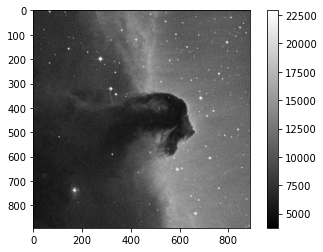

In [26]:
plt.imshow(image_data, cmap='gray')
plt.colorbar()

# To see more color maps
# http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps

Let's get some basic statistics about our image:

In [28]:
print('Min:', np.min(image_data))
print('Max:', np.max(image_data))
print('Mean:', np.mean(image_data))
print('Stdev:', np.std(image_data))
print('Median', np.median(image_data))

Min: 3759
Max: 22918
Mean: 9831.481676287574
Stdev: 3032.3927542049046
Median 9658.0


### Plotting a histogram

To make a histogram with `matplotlib.pyplot.hist()`, we'll need to cast the data from a 2D array to something one dimensional.

In this case, let's use the `ndarray.flatten()` to return a 1D numpy array.

In [29]:
print(type(image_data.flatten()))

<class 'numpy.ndarray'>


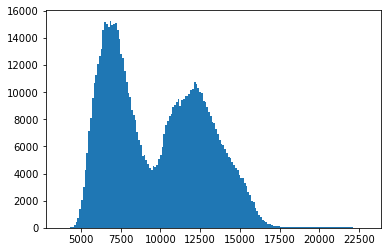

In [30]:
histogram = plt.hist(image_data.flatten(), bins='auto')

### Displaying the image with a logarithmic scale

What if we want to use a logarithmic color scale? To do so, we'll need to load the `LogNorm` object from `matplotlib`.

In [31]:
from matplotlib.colors import LogNorm

[Text(1, 0, '5,000'), Text(1, 0, '10,000'), Text(1, 0, '20,000')]

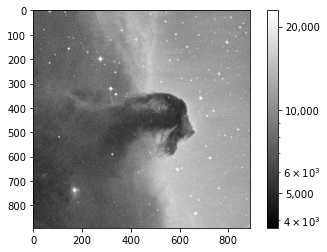

In [32]:
plt.imshow(image_data, cmap='gray', norm=LogNorm())

# I chose the tick marks based on the histogram above
cbar = plt.colorbar(ticks=[5.e3,1.e4,2.e4])
cbar.ax.set_yticklabels(['5,000','10,000','20,000'])

In [35]:
image_data_normed = image_data/np.median(image_data)

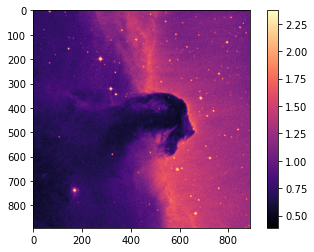

In [37]:
plt.imshow(image_data_normed, cmap="magma")
plt.colorbar()

## Basic image math: image stacking

You can also perform math with the image data like any other numpy array.  In this particular example, we'll stack several images of M13 taken with a ~10'' telescope.

Let's start by opening a series of FITS files and store the data in a list, which we've named `image_concat`.

In [14]:
base_url = 'http://data.astropy.org/tutorials/FITS-images/M13_blue_{0:04d}.fits'

image_list = [download_file(base_url.format(n), cache=True) 
              for n in range(1, 5+1)]
image_concat = [fits.getdata(image) for image in image_list]

Now we'll stack the images by summing the concatenated list.

In [15]:
# The long way
final_image = np.zeros(shape=image_concat[0].shape)

for image in image_concat:
    final_image += image

# The short way
# final_image = np.sum(image_concat, axis=0)

We're going to show the image, but need to decide on the best stretch. To do so let's plot a histogram of the data.

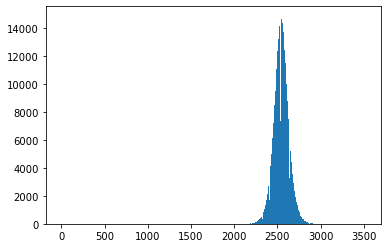

In [16]:
image_hist = plt.hist(final_image.flatten(), bins='auto')

We'll use the keywords `vmin` and `vmax` to set limits on the color scaling for `imshow`.

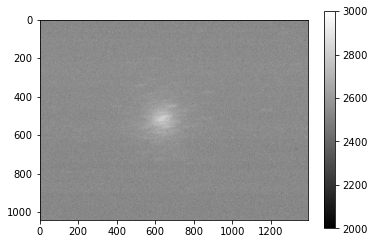

In [17]:
plt.imshow(final_image, cmap='gray', vmin=2E3, vmax=3E3)
plt.colorbar()

## Writing image data to a FITS file

We can do this with the `writeto()` method.

Warning: you'll receive an error if the file you are trying to write already exists.  That's why we've set `overwrite=True`.

In [18]:
outfile = 'stacked_M13_blue.fits'

hdu = fits.PrimaryHDU(final_image)
hdu.writeto(outfile, overwrite=True)

## Exercises

Determine the mean, median, and standard deviation of a part of the stacked M13 image where there is *not* light from M13.  Use those statistics with a sum over the part of the image that includes M13 to estimate the total light in this image from M13.

Show the image of the Horsehead Nebula, but in units of *surface brightness* (magnitudes per square arcsecond).
(Hint: the *physical* size of the image is 15x15 arcminutes.)

Now write out the image you just created, preserving the header the original image had, but add a keyword 'UNITS' with the value 'mag per sq arcsec'.
(Hint: it may be helpful to read the [astropy.io.fits](http://docs.astropy.org/en/stable/io/fits/index.html) documentation if you're not sure how to include both the header and the data.)